<a href="https://colab.research.google.com/github/Unopiece98/TCS---HumAIn/blob/master/Dataset_Extraction_and_Face_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
#This code was created in google colab and hence the commands that handle external files shall be different.

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#importing necessary libraries for dataset extraction from .json file

import os
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import requests
from io import BytesIO

In [8]:
#Needs to be run the first time you run this file. If you choose to use colab,these need to be run everytime runtimes are reset.
#These files load the pretrained face detector

!pip install mtcnn
!pip install tensorflow==1.12.1 opencv-contrib-python==4.1.0
!pip install tensorflow-gpu\>=1.12.0

     |████████████████████████████████| 2.3MB 3.5MB/s 
  Created wheel for mtcnn: filename=mtcnn-0.0.9-cp36-none-any.whl size=2257692 sha256=c85c10c40781c156b3c396582a1084786d878f3e1f50d252f3a9b8aaf9e6ceea
  Stored in directory: /root/.cache/pip/wheels/85/81/65/6363fa5aafd7a155c896591e0c7c6e27b69642aa82b9cbf076
Successfully built mtcnn
  ERROR: Could not find a version that satisfies the requirement tensorflow==1.12.1 (from versions: 0.12.1, 1.0.0, 1.0.1, 1.1.0rc0, 1.1.0rc1, 1.1.0rc2, 1.1.0, 1.2.0rc0, 1.2.0rc1, 1.2.0rc2, 1.2.0, 1.2.1, 1.3.0rc0, 1.3.0rc1, 1.3.0rc2, 1.3.0, 1.4.0rc0, 1.4.0rc1, 1.4.0, 1.4.1, 1.5.0rc0, 1.5.0rc1, 1.5.0, 1.5.1, 1.6.0rc0, 1.6.0rc1, 1.6.0, 1.7.0rc0, 1.7.0rc1, 1.7.0, 1.7.1, 1.8.0rc0, 1.8.0rc1, 1.8.0, 1.9.0rc0, 1.9.0rc1, 1.9.0rc2, 1.9.0, 1.10.0rc0, 1.10.0rc1, 1.10.0, 1.10.1, 1.11.0rc0, 1.11.0rc1, 1.11.0rc2, 1.11.0, 1.12.0rc0, 1.12.0rc1, 1.12.0rc2, 1.12.0, 1.12.2, 1.12.3, 1.13.0rc0, 1.13.0rc1, 1.13.0rc2, 1.13.1, 1.13.2, 1.14.0rc0, 1.14.0rc1, 1.14.0, 2.0.0a0, 2.0.0

In [9]:
#Change current working directory to the directory containing the .json file

os.chdir(r"/content/drive/My Drive/TCS HumAIn/Face Recognition Dataset/") 

#Since the .json file contains multiple Json objects, they shall be stored as a list of dictionaries in python

data = []
for line in open('Face_Recognition.json', 'r'):
    data.append(json.loads(line))

#data is now a list of dictionaries where each dictionary represents one entry into the dataset
#Now we check  if the label field in the entire dataset contains any unwanted fields. For example here we have 'Not_Face' as an undesirable label

label = []
a = len(data)
for i in range(0,a):
  for j in range(0,len(data[i]['annotation'])):
    k = data[i]['annotation'][j]['label']
    if len(k)!=0 and len(k)!=1:
      for p in range(0,len(k)):
        label.append(k[p])

#label now contains a sum total of all the labels in the entire dataset. Converting it to set allows us to see all unique entries within it, sans repetition.

print(set(label))



{'Age_40_50', 'E_Indian', 'Emotion_Happy', 'E_Hispanic', 'E_Asian', 'Not_Face', 'Age_30_40', 'G_ Female', 'Age_above_50', 'Age_below20', 'Emotion_Angry', 'E_Black', 'G_Male', 'E_Arab', 'Age_20_30', 'Emotion_Sad', 'Emotion_Neutral', 'E_White'}


In [0]:
#Data preprocessing
#Here we work to make the data easier to manipulate.
#First we add none values wherever needed. This is done becase separate models will classify Emotion, Age and Ethnicity.
#If time permits we shall also classify gender although it is not required by the problem statement.
#After adding nones, we sort the data so that we can easily split it into emotion, age, ethnicity and gender.
#We also remove the unwanted field

for i in range(0,a):
  for j in range(0,len(data[i]['annotation'])):
    k = data[i]['annotation'][j]['label']
    label = []
    if len(k)!=0 and len(k)!=1:
      for p in range(0,len(k)):
        label.append(k[p].split('_',1)[0].strip())
    if 'E' not in label:
      k.append('E_None')
    if 'G' not in label:
      k.append('G_None')
    if 'Age' not in label:
      k.append('Age_None')
    if 'Emotion' not in label:
      k.append('Emotion_None')
    if 'Not' in label:
      k.remove('Not_Face')
    k.sort(key = lambda x: x.split('_')[0])#to sort the values only by label names

In [0]:
#Since one image may have many faces within it, the same image and image dimensions would be loaded multiple times unnecassarily. 
#In order to solve this issue memoization is used

cache = {}
def img_ret(i):
  if cache.get(i) is not None:
    return cache[i]
  cache[i] = [Image.open(BytesIO(requests.get(data[i]['content']).content)),data[i]['annotation'][0]['imageWidth'],data[i]['annotation'][0]['imageHeight']]
  return cache[i]

#Define the image cropping function

def img_crop_resize(i,j):
  Image_call = img_ret(i)
  Im = Image_call[0]
  w = Image_call[1]
  h = Image_call[2]
  x1 = data[i]['annotation'][j]['points'][0]['x']*w
  y1 = data[i]['annotation'][j]['points'][0]['y']*h
  x2 = data[i]['annotation'][j]['points'][1]['x']*w
  y2 = data[i]['annotation'][j]['points'][1]['y']*h
  width = 299
  height = 299
  return np.array(Im.crop((x1,y1,x2,y2)).resize((width, height), Image.ANTIALIAS))#antialias is one of the best filters for resizing the image

  
  

In [0]:
Age = []
Ethnicity = []
Emotion = []
Gender = []
Images =  []
Imagesnp = np.array(Images)
for i in range(0,a):
  for j in range(0,len(data[i]['annotation'])):
    k = data[i]['annotation'][j]['label']
    if len(k)!=0 and len(k)!=1:
      Age.append(data[i]['annotation'][j]['label'][0].split('_',1)[1])
      Ethnicity.append(data[i]['annotation'][j]['label'][1].split('_',1)[1])
      Emotion.append(data[i]['annotation'][j]['label'][2].split('_',1)[1])
      Gender.append(data[i]['annotation'][j]['label'][3].split('_',1)[1])
      Images.append(img_crop_resize(i,j))



In [15]:
Imagesnp = np.array([[[coord for coord in xk] for xk in xj] for xj in Images], ndmin=3)
print(Imagesnp.shape)


(351, 299, 299)


In [16]:
#Creating Dataframes and splitting into train and testing data as well as performing one hot encoding

import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

#Age
print(type(Images))
Agedf = pd.DataFrame(list(zip(Imagesnp,Age)),columns=['Images','Age'])
Agedf.dropna()
print(Agedf.head())
Age_labels = list(set(Age))
X_Age = Agedf.iloc[:,0].values
Y_Age = Agedf.iloc[:,1].values
X_Age_train,X_Age_test,Y_Age_train,Y_Age_test = train_test_split(X_Age, Y_Age, test_size = 0.25)





Using TensorFlow backend.


<class 'list'>
                                              Images      Age
0  [[[65, 34, 31], [67, 37, 34], [71, 42, 39], [7...  below20
1  [[[229, 40, 2], [225, 56, 11], [217, 77, 23], ...    20_30
2  [[[197, 148, 127], [197, 148, 127], [197, 148,...    20_30
3  [[[196, 180, 164], [195, 179, 163], [194, 177,...    20_30
4  [[[108, 137, 19], [107, 136, 18], [105, 134, 1...    20_30


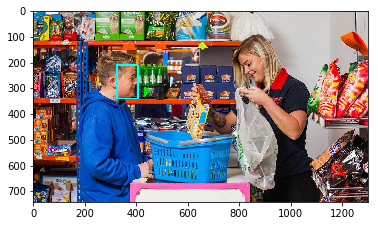

In [23]:
#Face Detection Example
from mtcnn.mtcnn import MTCNN
import cv2

img = img_ret(0)[0]
im = np.array(img)
detector = MTCNN()
result = detector.detect_faces(im)
bounding_box = result[0]['box']
keypoints = result[0]['keypoints']
cv2.rectangle(im,(bounding_box[0], bounding_box[1]),(bounding_box[0]+bounding_box[2], bounding_box[1] + bounding_box[3]),(0,255,255), 5)

plt.imshow(im)

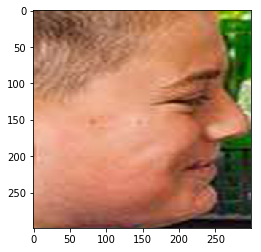

In [24]:
#cropped face 

plt.imshow(img.crop((bounding_box[0], bounding_box[1], bounding_box[0]+bounding_box[2], bounding_box[1] + bounding_box[3])).resize((299,299), Image.ANTIALIAS))